In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from IPython.display import display, clear_output
import pandas as pd
import time
import json

from itertools import product
from collections import namedtuple
from collections import OrderedDict


In [2]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)

    def forward(self, t):
        t = t

        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t)

        t = self.fc2(t)
        t = F.relu(t)
        t = self.out(t)

        return t


In [3]:
class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs


In [4]:
class RunManager():
    def __init__(self):

        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.epoch_start_time = None

        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None

        self.network = None
        self.loader = None
        self.tb = None

    def begin_run(self, run, network, loader):

        self.run_start_time = time.time()

        self.run_params = run
        self.run_count += 1

        self.network = network
        self.loader = loader
        self.tb = SummaryWriter(comment=f'-{run}')

        images, labels = next(iter(self.loader))
        grid = torchvision.utils.make_grid(images)

        self.tb.add_image('images', grid)
        self.tb.add_graph(self.network, images.to(getattr(run, 'device', 'cpu')))

    def end_run(self):
        self.tb.close()
        self.epoch_count = 0

    def begin_epoch(self):
        self.epoch_start_time = time.time()

        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0

    def end_epoch(self):

        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time

        loss = self.epoch_loss / len(self.loader.dataset)
        accuracy = self.epoch_num_correct / len(self.loader.dataset)

        self.tb.add_scalar('Loss', loss, self.epoch_count)
        self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)

        for name, param in self.network.named_parameters():
            self.tb.add_histogram(name, param, self.epoch_count)
            self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)

        results = OrderedDict()
        results["run"] = self.run_count
        results["epoch"] = self.epoch_count
        results['loss'] = loss
        results["accuracy"] = accuracy
        results['epoch duration'] = epoch_duration
        results['run duration'] = run_duration
        for k, v in self.run_params._asdict().items():
            results[k] = v
        self.run_data.append(results)

        df = pd.DataFrame.from_dict(self.run_data, orient='columns')

        clear_output(wait=True)
        display(df)

    def track_loss(self, loss, batch):
        self.epoch_loss += loss.item() * batch[0].shape[0]

    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)

    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()

    def save(self, fileName):

        pd.DataFrame.from_dict(
            self.run_data, orient='columns').to_csv(f'{fileName}.csv')

        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)


In [5]:
train_set = torchvision.datasets.FashionMNIST(
    root='/.data/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)


# calculating mean and std Easy Way

In [6]:
loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), num_workers=1)
data = next(iter(loader))
mean = data[0].mean()
std = data[0].std()
mean, std

# calculating mean and std Hard Way

In [7]:
loader = torch.utils.data.DataLoader(train_set, batch_size=1000, num_workers=1)
number_of_pixels = len(train_set) * 28 * 28
data = next(iter(loader))

total_sum = 0
for batch in loader:
    total_sum += batch[0].sum()

mean = total_sum / number_of_pixels

sum_of_square_error = 0
for batch in loader:
    sum_of_square_error += ((batch[0] - mean).pow(2)).sum()

std = torch.sqrt(sum_of_square_error/number_of_pixels)

mean, std


(tensor(0.2860), tensor(0.3530))

In [ ]:
import matplotlib.pyplot as plt

plt.hist(data[0].flatten())
plt.axvline(data[0].mean())


In [8]:
train_set_normal = torchvision.datasets.FashionMNIST(
    root='/.data/',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]))

In [ ]:
loader = torch.utils.data.DataLoader(train_set_normal, batch_size=len(train_set), num_workers=1)
data = next(iter(loader))
data[0].mean(), data[0].std()

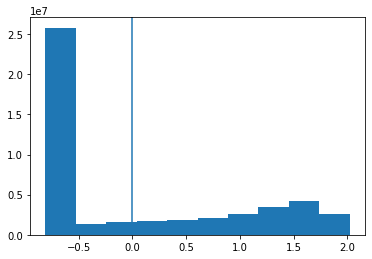

In [ ]:
plt.hist(data[0].flatten())
plt.axvline(data[0].mean())

In [ ]:
trainsets = {
    'not_normal': train_set
    ,'normal': train_set_normal
}

In [ ]:
params = OrderedDict(
      lr = [.01]
    , batch_size = [1000]
    , num_workers = [1]
    , device = ['cuda']
    , trainset = ['not_normal', 'normal']
)
m = RunManager()
for run in RunBuilder.get_runs(params):

    device = torch.device(run.device)
    network = Network().to(device)
    loader = DataLoader(
          trainsets[run.trainset]
        , batch_size=run.batch_size
        , num_workers=run.num_workers
    )
    optimizer = optim.Adam(network.parameters(), lr=run.lr)

    m.begin_run(run, network, loader)
    for epoch in range(20):
        m.begin_epoch()
        for batch in loader:

            images = batch[0].to(device)
            labels = batch[1].to(device)
            preds = network(images) # Pass Batch
            loss = F.cross_entropy(preds, labels) # Calculate Loss
            optimizer.zero_grad() # Zero Gradients
            loss.backward() # Calculate Gradients
            optimizer.step() # Update Weights

            m.track_loss(loss, batch)
            m.track_num_correct(preds, labels)
        m.end_epoch()
    m.end_run()
m.save('results')

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,num_workers,device,trainset
0,1,1,0.975419,0.626600,9.246496,10.198430,0.01,1000,1,cuda,not_normal
1,1,2,0.531311,0.795883,9.162857,19.521333,0.01,1000,1,cuda,not_normal
2,1,3,0.431785,0.840700,9.011059,28.695866,0.01,1000,1,cuda,not_normal
3,1,4,0.375355,0.862933,9.036098,37.874992,0.01,1000,1,cuda,not_normal
4,1,5,0.341332,0.874933,9.031938,47.064939,0.01,1000,1,cuda,not_normal
5,1,6,0.325817,0.879750,8.968310,56.189191,0.01,1000,1,cuda,not_normal
6,1,7,0.308080,0.886350,8.995345,65.344319,0.01,1000,1,cuda,not_normal
7,1,8,0.298184,0.889833,9.043527,74.515665,0.01,1000,1,cuda,not_normal
8,1,9,0.284420,0.894833,9.070665,83.729901,0.01,1000,1,cuda,not_normal
9,1,10,0.274058,0.897633,8.961781,92.832953,0.01,1000,1,cuda,not_normal


In [ ]:
pd.DataFrame.from_dict(m.run_data).sort_values('accuracy', ascending=False)

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,num_workers,device,trainset
39,2,20,0.223844,0.916383,13.406866,272.366053,0.01,1000,1,cuda,normal
37,2,18,0.224165,0.915350,13.310951,245.184824,0.01,1000,1,cuda,normal
38,2,19,0.223984,0.915033,13.459873,258.797305,0.01,1000,1,cuda,normal
36,2,17,0.229144,0.913400,13.277092,231.714617,0.01,1000,1,cuda,normal
35,2,16,0.234303,0.912167,13.335901,218.276414,0.01,1000,1,cuda,normal
19,1,20,0.232171,0.912150,9.183941,184.868719,0.01,1000,1,cuda,not_normal
34,2,15,0.239350,0.910200,13.367460,204.767991,0.01,1000,1,cuda,normal
18,1,19,0.239461,0.909867,9.087331,175.534394,0.01,1000,1,cuda,not_normal
33,2,14,0.243165,0.908817,13.429470,191.221850,0.01,1000,1,cuda,normal
17,1,18,0.244694,0.908267,9.056958,166.305916,0.01,1000,1,cuda,not_normal
